### Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix

from src.utils.io import read_json
from src.utils.plotting import *
from conf_prediction.utils import *
from conf_prediction.abs_error import conformal_calibrate
from conf_prediction.quantile import *

datasets = ['hc18', 'jsrt', 'ph2', 'psfhs', 'scd', 'irca', 'wbc_cv', 'wbc_jtsc', 'isic 2018', 'nucls']

def process_dataset(data, metric='Dice'):
    real_scores = []
    rca_scores = []
    for x in data:
        real = x['Real score'][metric]
        rca_dice_list = x['RCA score'][metric]

        if not np.all(np.isfinite(real)):
            continue

        for rca_array in rca_dice_list:
            rca_array = np.array(rca_array)
            if rca_array.ndim == 1:
                rca_array = rca_array.reshape(-1, 1)

        real_scores.append(real)
        rca_scores.append(np.array([v for v in rca_dice_list]))

    return {'Real score': real_scores, 'RCA score': rca_scores}


data = {'sam': {}, 'useg': {}, 'atlas-ra': {}, 'atlas': {}}
metric = 'Dice'

paths = {
    'sam': 'results/sam2/',
    'useg': 'results/universeg',
    'atlas-ra': 'results/atlas-ra/',
    'atlas': 'results/atlas/',
}

for dataset in datasets:
    for model, base_path in paths.items():
        test_data = read_json(os.path.join(base_path, f"{dataset}_test.json"))
        cal_data = read_json(os.path.join(base_path, f"{dataset}_cal.json"))
        data[model][dataset] = {
            'test': process_dataset(test_data, metric),
            'cal': process_dataset(cal_data, metric)
        }

In [12]:
datasets = ['irca', 'jsrt']
paths = {'useg': 'results/universeg-no-ra/'}

for dataset in datasets:
    for model, base_path in paths.items():
        test_data = read_json(os.path.join(base_path, f"{dataset}_test.json"))
        data[model][dataset] = {
            'test': process_dataset(test_data, metric),
        }

### Plotting

In [2]:
def reduce(dataset, predictor='mean', n=8):
    res = {}
    res['Real'] = dataset['Real score']
    
    rca = np.array(dataset['RCA score'])[:, :n]
    rca = np.ma.masked_invalid(rca)
    
    if predictor == 'mean':
        rca = np.mean(rca, axis=1)
    elif predictor == 'max':
        rca= np.max(rca, axis=1)
    elif predictor == 'min':
        rca = np.min(rca, axis=1)

    res['Predicted'] = rca.tolist()
    return res

predictors = {
    'useg': 'max',
    'sam': 'mean',
    'atlas': 'max',
    'atlas-ra': 'max'
}

data_red = {model: {} for model in predictors}

for dataset in datasets:
    for model, predictor in predictors.items():
        data_red[model][dataset] = {
            'test': reduce(data[model][dataset]['test'], predictor=predictor),
            'cal': reduce(data[model][dataset]['cal'], predictor=predictor)
        }

datasets_list = list(data_red['useg'].keys())
dataset_class_pairs = []

for dataset_name in datasets_list:
    real = np.array(data_red['useg'][dataset_name]['test']['Real'])
    n_classes = real.shape[1] if real.ndim == 2 else 1
    for class_idx in range(n_classes):
        dataset_class_pairs.append((dataset_name, class_idx))

n_plots = len(dataset_class_pairs)

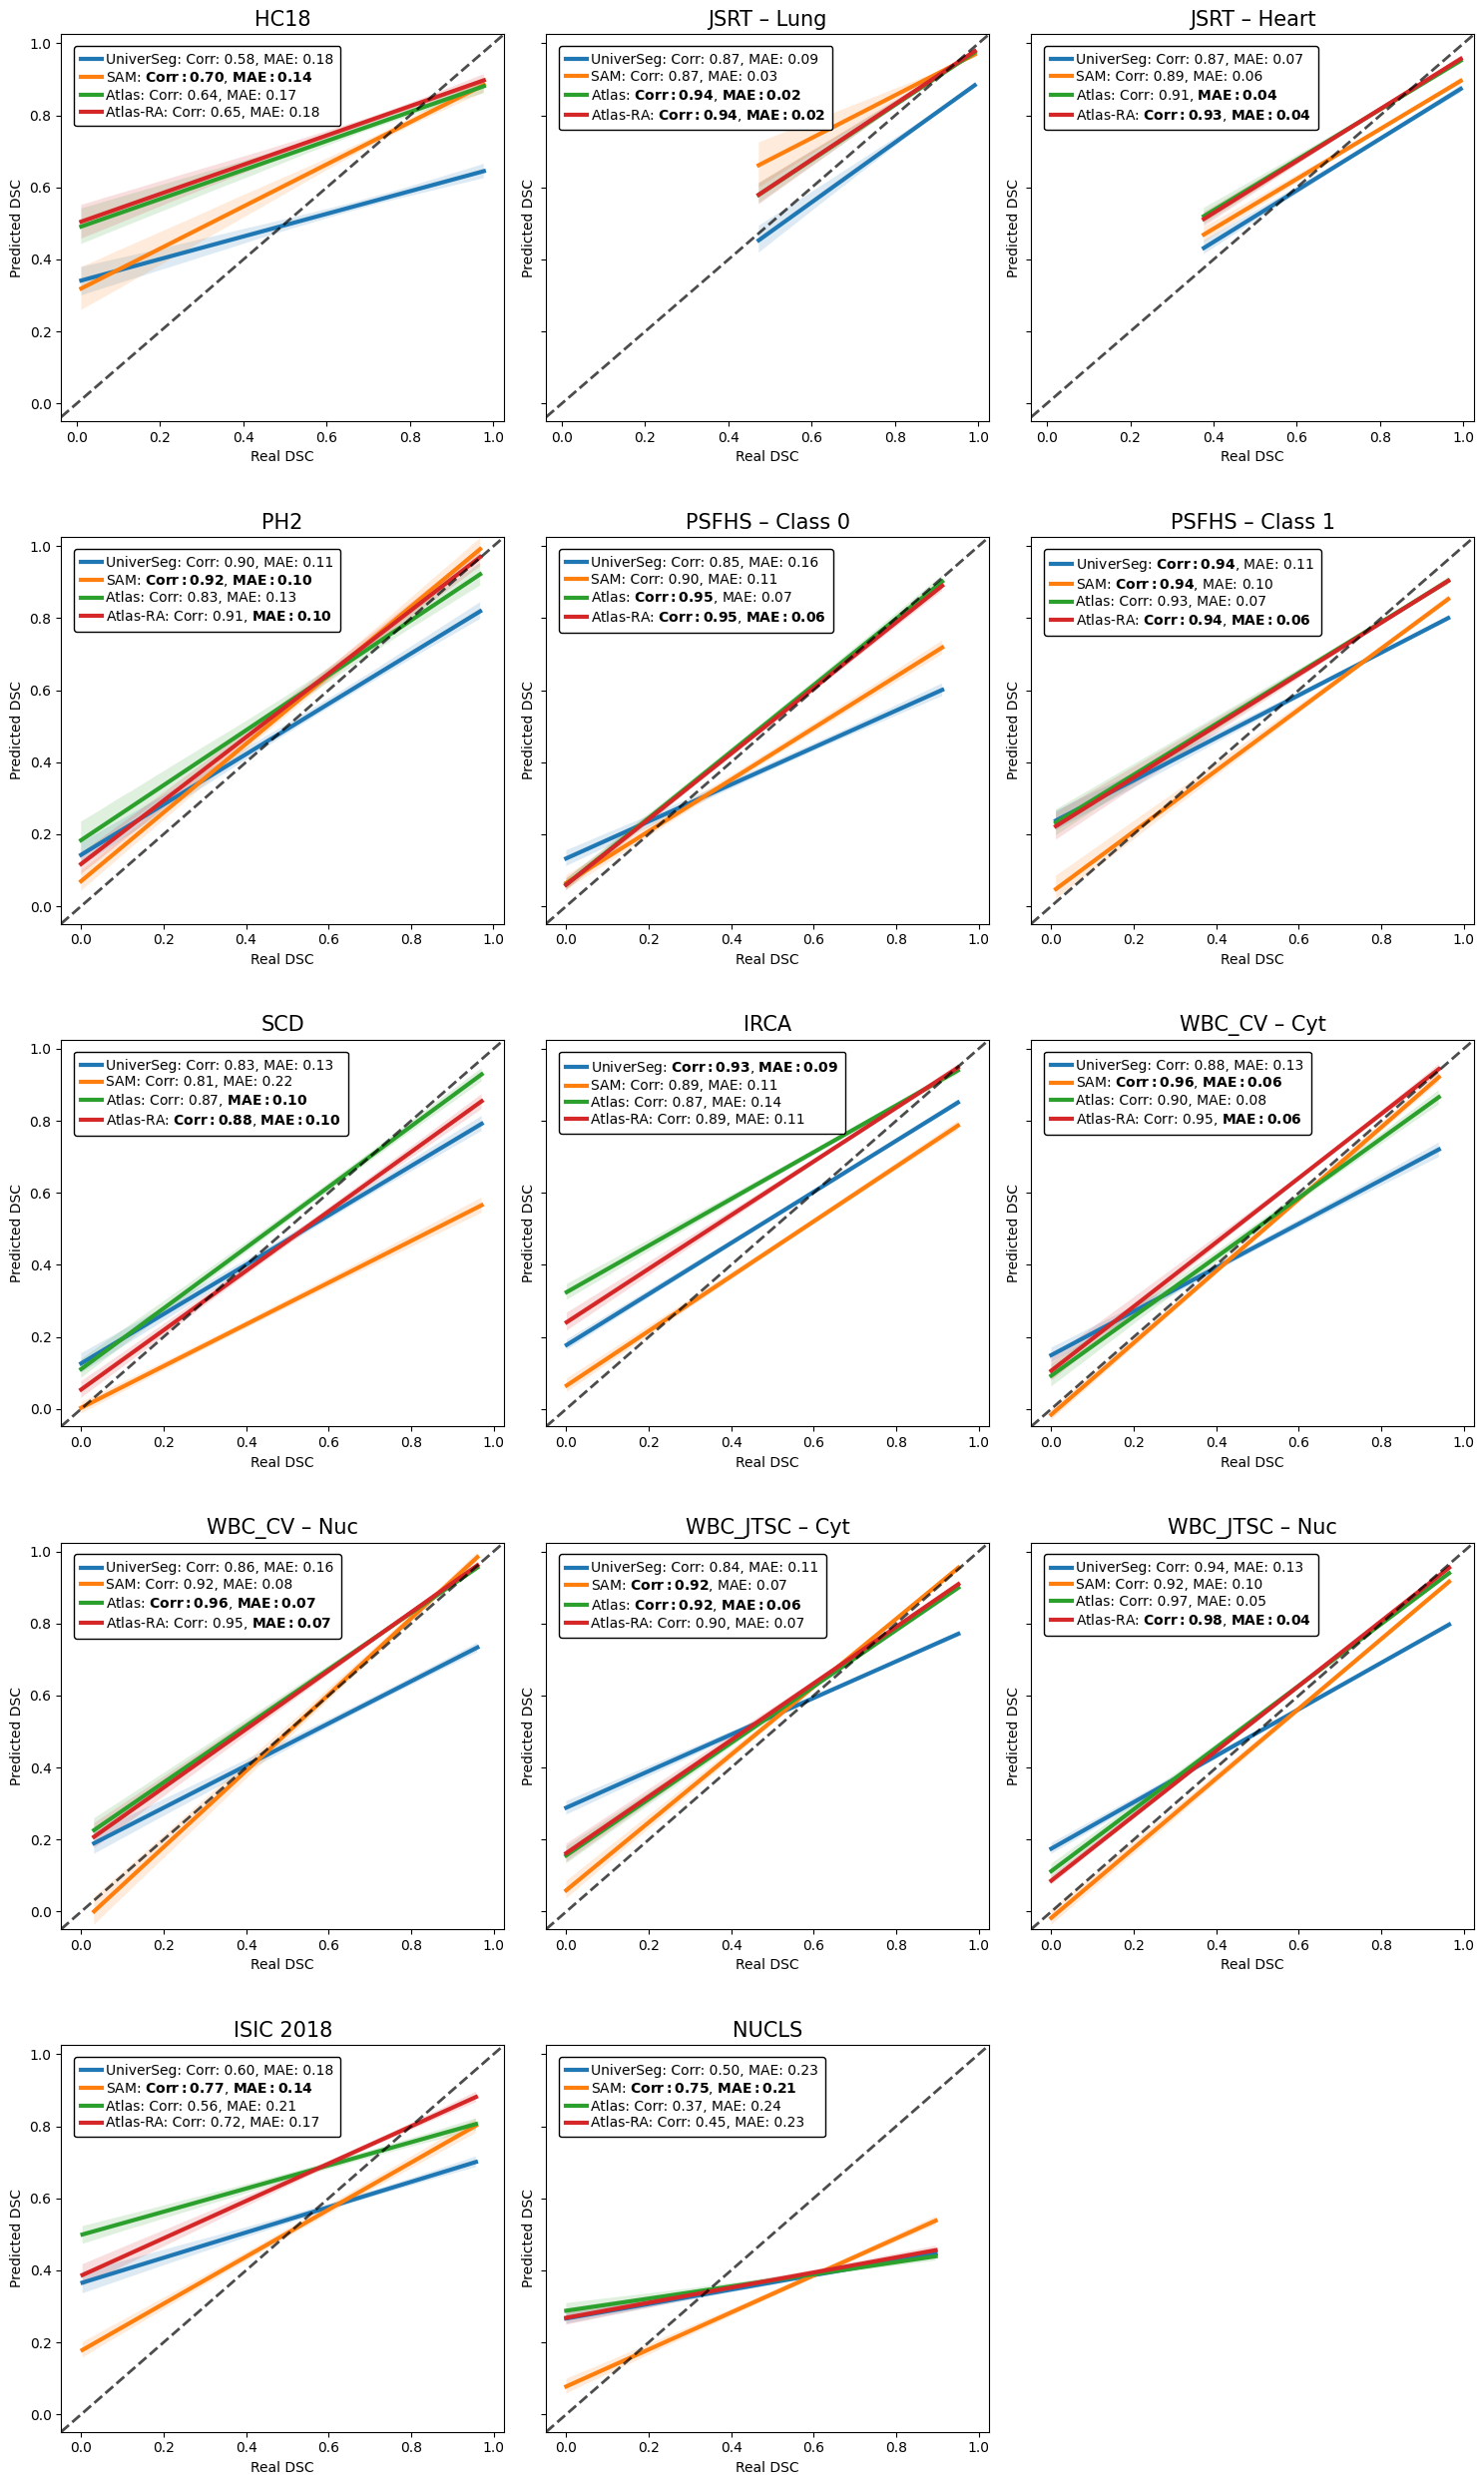

In [3]:
fig = plot_regressions(data_red, dataset_class_pairs)

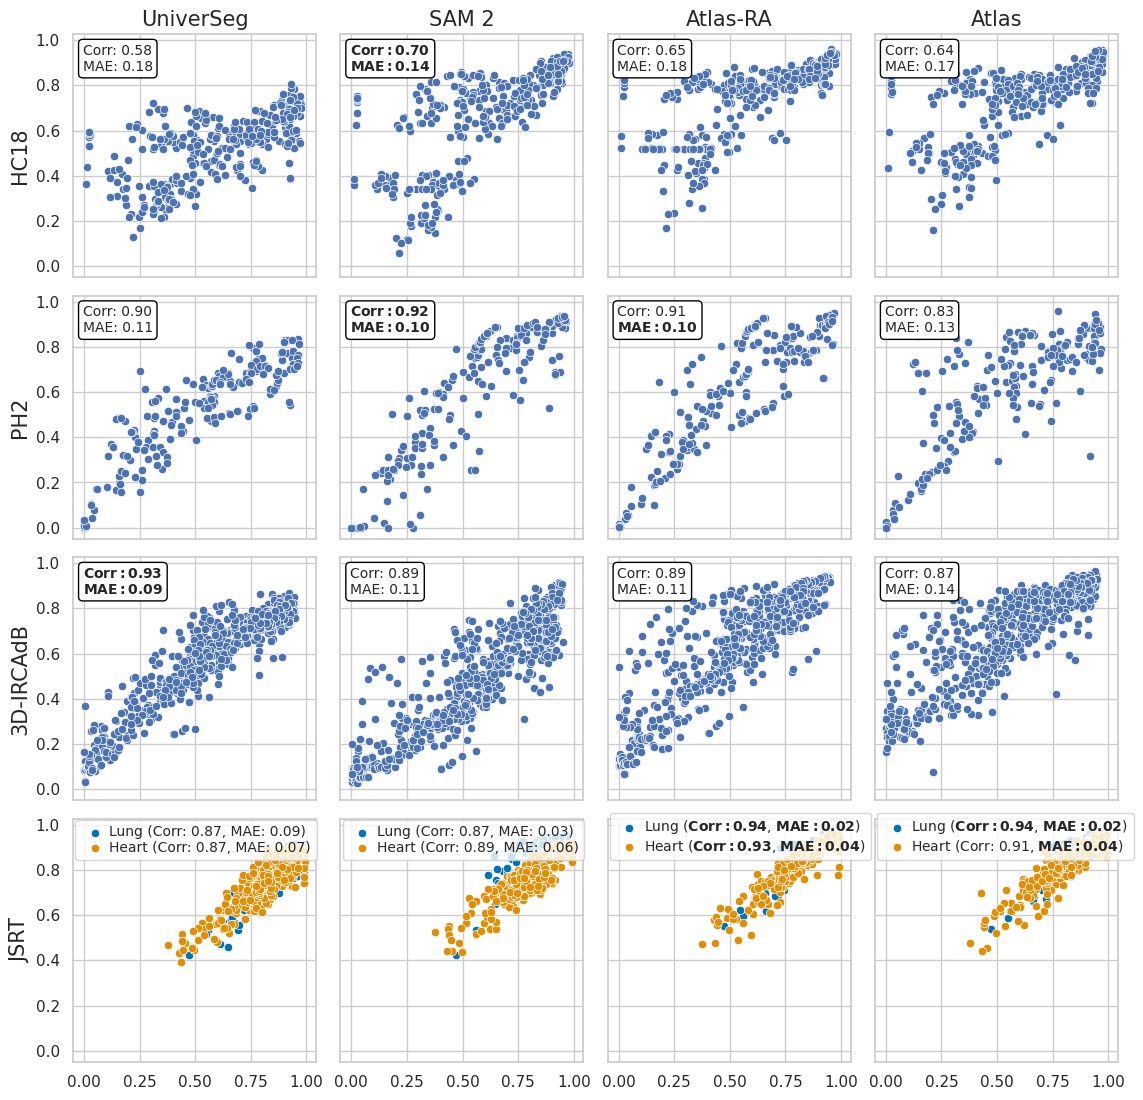

In [4]:
plot_args = {
    'titles': ['UniverSeg', 'SAM 2', 'Atlas-RA', 'Atlas'],
    'n_cols': 4,
    'fontsize': 15
}

hc18_dict_dice = {
    'dataset': 'HC18',
    'results': [
        data_red['useg']['hc18']['test'],
        data_red['sam']['hc18']['test'],
        data_red['atlas-ra']['hc18']['test'],
        data_red['atlas']['hc18']['test']
    ]
}

ircadb_dict_dice = {
    'dataset': '3D-IRCAdB',
    'results': [
        data_red['useg']['irca']['test'],
        data_red['sam']['irca']['test'],
        data_red['atlas-ra']['irca']['test'],
        data_red['atlas']['irca']['test']
    ]
}

ph2_dict_dice = {
    'dataset': 'PH2',
    'results': [
        data_red['useg']['ph2']['test'],
        data_red['sam']['ph2']['test'],
        data_red['atlas-ra']['ph2']['test'],
        data_red['atlas']['ph2']['test']
    ]
}

jsrt_dict_dice = {
    'dataset': 'JSRT',
    'is_multiclass': True,
    'class_names': ['Lung', 'Heart'],
    'results': [
        data_red['useg']['jsrt']['test'],
        data_red['sam']['jsrt']['test'],
        data_red['atlas-ra']['jsrt']['test'],
        data_red['atlas']['jsrt']['test']
    ]
}

results_1 = [hc18_dict_dice, ph2_dict_dice, ircadb_dict_dice, jsrt_dict_dice]

fig = plot_results(results_1, **plot_args)


### RCA estimations

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

def compute_results_df(datasets, model, split, data, estimator='max', n=32):
    """
    Compute MAE and correlation per class for the given model and split.

    Parameters:
    - datasets: list of dataset names
    - model: 'sam', 'useg' or 'atlas'AssertionError
    - split: 'test' or 'cal'
    - data: nested dict structure data[model][split][dataset]
    - n: number of reference predictions to use (up to 50)

    Returns:
    - pd.DataFrame with MAE and correlation per class, per dataset.
    """
    results = {}

    for dataset in datasets:
        scores = data[model][dataset][split]
        real = np.array(scores['Real score'])
        rca = np.array(scores['RCA score'])[:, :n]
        rca = np.ma.masked_invalid(rca)

        if estimator == 'mean':
            rca = rca.mean(axis=1)
        elif estimator == 'max':
            rca = rca.max(axis=1)
        elif estimator == 'min':
            rca = rca.min(axis=1)

        if real.ndim == 1:
            real = real.reshape(-1, 1)
        if rca.ndim == 1:
            rca = rca.reshape(-1, 1)

        abs_error = np.abs(real - rca)
        mae = np.mean(abs_error, axis=0)

        correlations = [
            pearsonr(real[:, i], rca[:, i])[0]
            for i in range(real.shape[1])
        ]

        results[dataset.upper()] = {
            **{f'Class {i} MAE': mae[i] for i in range(len(mae))},
            **{f'Class {i} Corr': correlations[i] for i in range(len(correlations))}
        }

    return pd.DataFrame.from_dict(results, orient='index')

results_df = compute_results_df(datasets, 'useg', 'test', data, estimator='max', n=8)
results_df

,Class 0 MAE,Class 0 Corr,Class 1 MAE,Class 1 Corr
IRCA,0.125429,0.861306,NaN,NaN
JSRT,0.101367,0.872719,0.080146,0.856288
PH2,0.134126,0.814282,NaN,NaN
PSFHS,0.160731,0.882752,0.112430,0.917040
SCD,0.110457,0.873052,NaN,NaN
WBC_CV,0.139195,0.890453,0.162922,0.893098
WBC_JTSC,0.121530,0.829677,0.137131,0.914051


### Conformal range prediction

Let $\hat{y}(x) = \{\hat{y}^{(1)}(x), \dots, \hat{y}^{(m)}(x)\}$ be the set of DSC estimates for a given input segmentation $x$.


##### Absolute error based
Define two possible predictors:

- $\hat{y}_{\text{mean}}(x) = \frac{1}{m} \sum_{j=1}^m \hat{y}^{(j)}(x)$  
- $\hat{y}_{\text{max}}(x) = \max_j \hat{y}^{(j)}(x)$

Given a true DSC score $y$ and a predicted score $\hat{y}_\text{pred}(x) \in \{\hat{y}_{\text{mean}}(x), \hat{y}_{\text{max}}(x)\}$, define the nonconformity score as:

$\quad S(x, y) = |y - \hat{y}_\text{pred}(x)| \quad \text{or} \quad S(x, y) = \frac{|y - \hat{y}_\text{pred}(x)|}{\sigma(\hat{y}(x))}$

Where $\sigma(\hat{y}(x))$ is one of:

- **Standard deviation**:  
  $\sigma(\hat{y}(x)) = \sqrt{\frac{1}{m - 1} \sum_{j=1}^m (\hat{y}^{(j)}(x) - \hat{y}_{\text{mean}}(x))^2}$

- **IQR-based**:  
  $\sigma_{\text{IQR}}(\hat{y}(x)) = \frac{Q_3 - Q_1}{1.349}$

- **Trimmed standard deviation**:  
  $\sigma_{\text{trim}}(\hat{y}(x)) = \text{std}\left(\{\hat{y}^{(j)}(x) \mid \hat{y}^{(j)}(x) \geq \text{percentile}_\gamma\}\right)$



Given calibration scores $S_1, \dots, S_n$ and a level $\alpha$, compute:

$\quad \hat{q}_\alpha = \text{Quantile}(S_1, \dots, S_n;\ \frac{(n + 1)(1 - \alpha)}{n})$

Then, the prediction interval for a new input $x$ is:

- Without scaling:
$[\hat{y}_\text{pred}(x) - \hat{q}_\alpha,\ \hat{y}_\text{pred}(x) + \hat{q}_\alpha] \cap [0, 1]$ 

- With scaling:
$[\hat{y}_\text{pred}(x) - \hat{q}_\alpha \cdot \sigma(\hat{y}(x)),\ \hat{y}_\text{pred}(x) + \hat{q}_\alpha \cdot \sigma(\hat{y}(x))] \cap [0, 1]$ 

---
##### Quantile based

We define a prediction interval based on the empirical quantiles $p_\ell$ and $p_h$.
Given a sample of predictions $\hat{y}(x)$,  
define the empirical prediction band as:

$\quad [\hat{q}_\ell(x), \hat{q}_h(x)] = \left[\text{Quantile}(\hat{y}(x),\ p_\ell),\ \text{Quantile}(\hat{y}(x),\ p_h)\right]$

For a calibration set and a level $\alpha$ we compute the non-conformity scores:

$\quad S(x, y) = \max\{\hat{q}_\ell(x) - y,\ y - \hat{q}_h(x)\}$  

We then determine inflation margin from the calibration nonconformity scores:

$Q_{1-\alpha}= \text{Quantile}(S^{(1)}, \dots, S^{(n)};\ 1 - \alpha)$  

Finally, for each test input $x$, we construct the prediction interval as

$\quad \left[\hat{q}_\ell(x) - Q_{1-\alpha}, \ \hat{q}_h(x) + Q_{1-\alpha}\right] \cap [0,1]$

#### Metrics

In [6]:
def compute_interval_metrics(calibration_results, datasets):
    """
    Compute interval size metrics for each dataset, class, and method.

    Parameters:
    - calibration_results: dict[dataset][method] = list of dicts with keys 'class' and 'intervals'
    - datasets: list of dataset names 
    """
    all_rows = []

    for dataset in datasets:
        method_dict = calibration_results[dataset]  # dict of {method: list of class dicts}
        for method_name, class_interval_list in method_dict.items():
            for k, class_entry in enumerate(class_interval_list):
                intervals = class_entry['intervals']

                # Safely cast all values to floats
                lower_bounds = np.array([float(i[0]) for i in intervals])
                upper_bounds = np.array([float(i[1]) for i in intervals])
                widths = upper_bounds - lower_bounds

                row = {
                    'dataset': dataset,
                    'class': k,
                    'method': method_name,
                    'mean_width': np.mean(widths),
                    'median_width': np.median(widths),
                    'std_width': np.std(widths),
                    'q25_width': np.percentile(widths, 25),
                    'q75_width': np.percentile(widths, 75),
                }
                all_rows.append(row)

    return pd.DataFrame(all_rows)

In [7]:
alpha = 0.1
n = 50
models = ['atlas-ra', 'sam']
combinations = [(e, s) for e in ['mean'] for s in ['abs', 'std']]
all_metrics = []

for m in models:
    res_sam = data[m]

    calibration_results = {}

    for dataset in datasets:
        conf_results = {}

        # Quantile-based methods
        conf_results['quantile'] = quantile_calibrate(
            res_sam[dataset], n=n,
            p_l=0.4, p_h=0.95,
            alpha=alpha
        )
        conf_results['quantile_asym'] = quantile_calibrate_asymm(
            res_sam[dataset], n=n,
            p_l=0.4, p_h=0.95,
            alpha_l=0.02, alpha_u=0.08
        )
        conf_results['quantile_adaptative'] = quantile_calibrate_adaptative(
            res_sam[dataset], n=n,
            p_l=0.4, p_h=0.95,
            alpha=alpha
        )

        # Regression-based methods
        for estimator, sigma_type in combinations:
            label = f'{estimator} + {sigma_type}'
            conf_results[label] = conformal_calibrate(
                res_sam[dataset], n=n,
                estimator=estimator,
                sigma_type=sigma_type,
                alpha=alpha
            )

        calibration_results[dataset] = conf_results

    df = compute_interval_metrics(calibration_results, datasets)
    df['model'] = m  
    all_metrics.append(df)

df_metrics = pd.concat(all_metrics, ignore_index=True)


In [15]:
idx = df_metrics.groupby(['dataset', 'class'])['median_width'].idxmin()

best_df = df_metrics.loc[idx].reset_index(drop=True)

best_summary = best_df[['dataset', 'class', 'method', 'model', 'median_width', 'q75_width']]
best_summary

,dataset,class,method,model,median_width,q75_width
0,hc18,0,mean + abs,atlas-ra,0.455395,0.455395
1,irca,0,mean + abs,atlas-ra,0.309955,0.309955
2,isic 2018,0,mean + std,atlas-ra,0.497206,0.574845
3,jsrt,0,quantile_asym,atlas-ra,0.066893,0.076524
4,jsrt,1,quantile,atlas-ra,0.179382,0.196320
5,nucls,0,quantile_adaptative,sam,0.491969,0.663550
6,ph2,0,quantile_adaptative,atlas-ra,0.383906,0.543205
7,psfhs,0,quantile_adaptative,atlas-ra,0.228795,0.329911
8,psfhs,1,quantile,sam,0.245685,0.277426
9,scd,0,quantile,sam,0.563916,0.652341


#### Plots

Number of calibration samples: 317


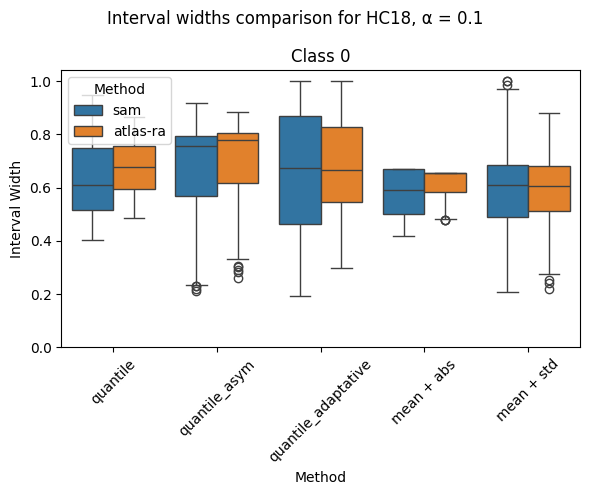

Number of calibration samples: 288


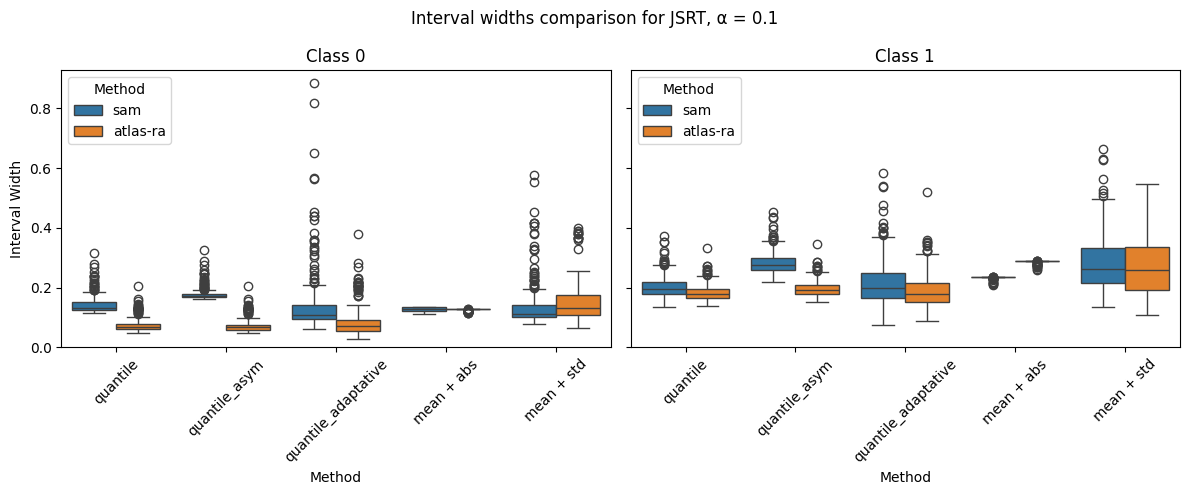

Number of calibration samples: 207


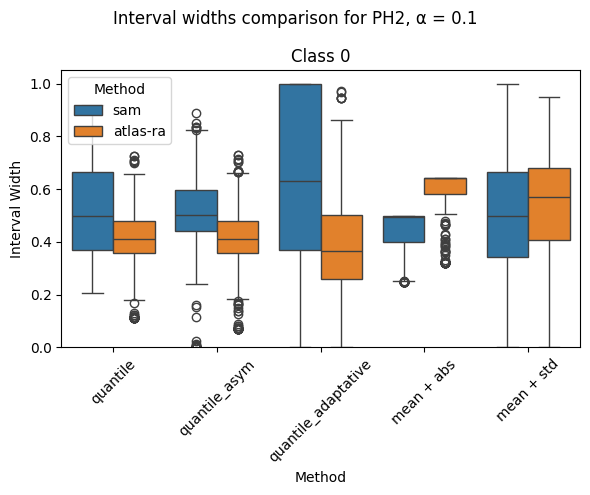

Number of calibration samples: 312


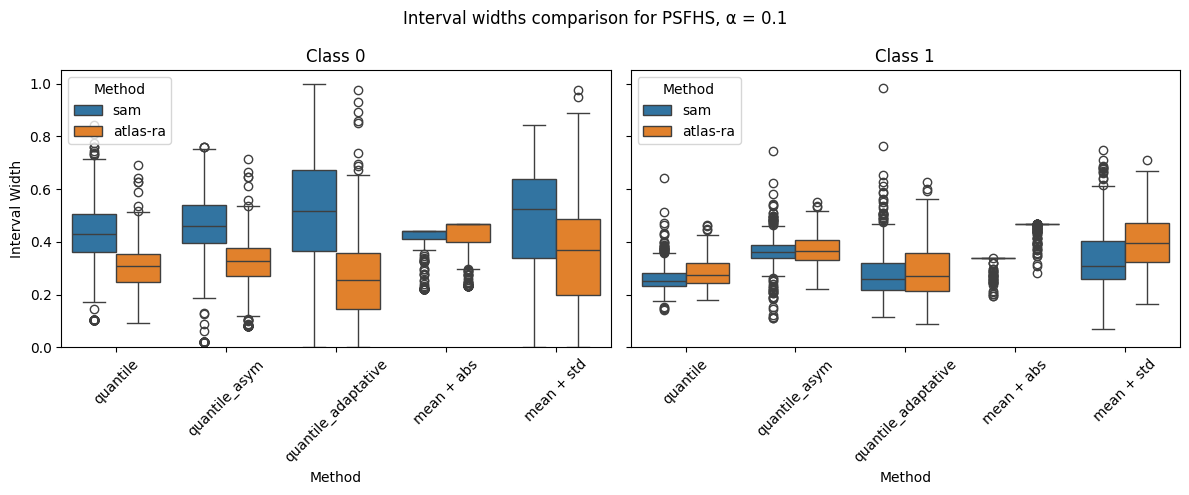

Number of calibration samples: 440


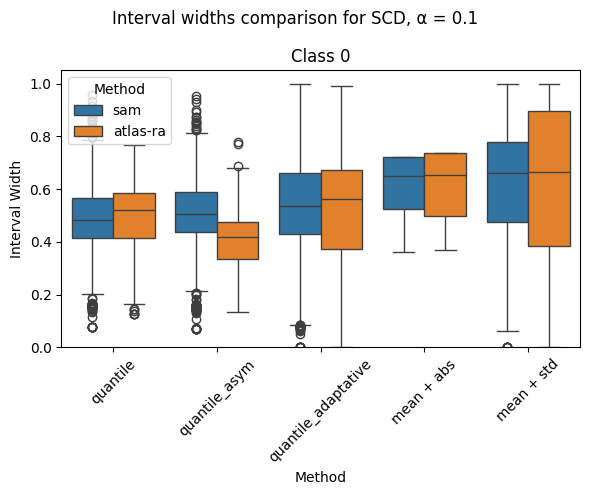

Number of calibration samples: 398


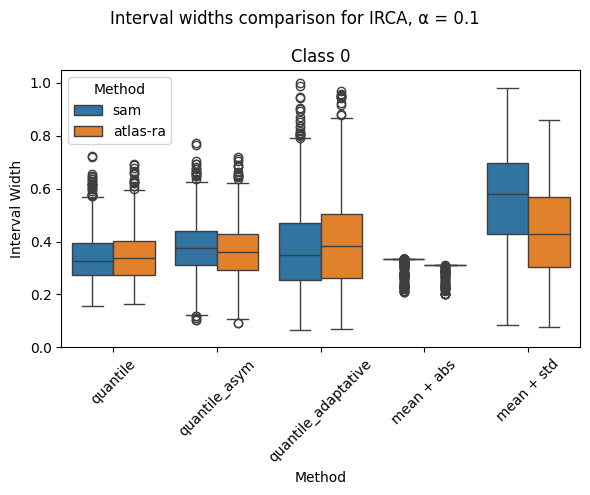

Number of calibration samples: 295


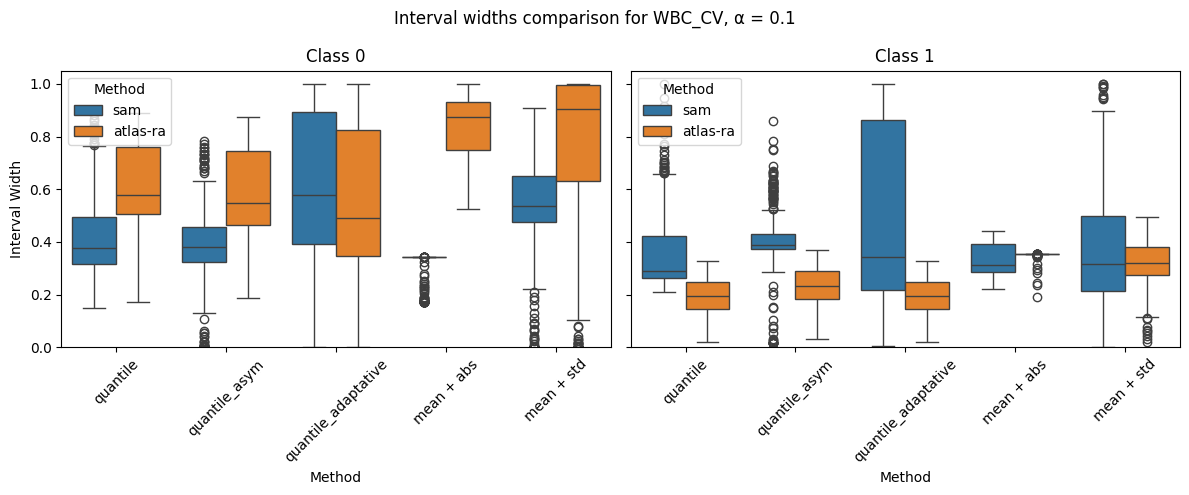

Number of calibration samples: 825


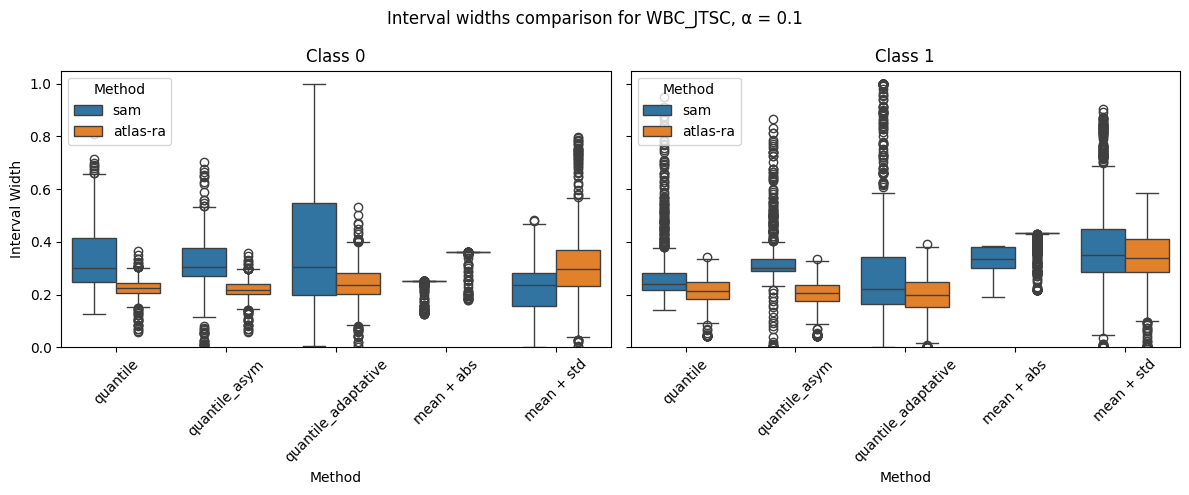

Number of calibration samples: 649


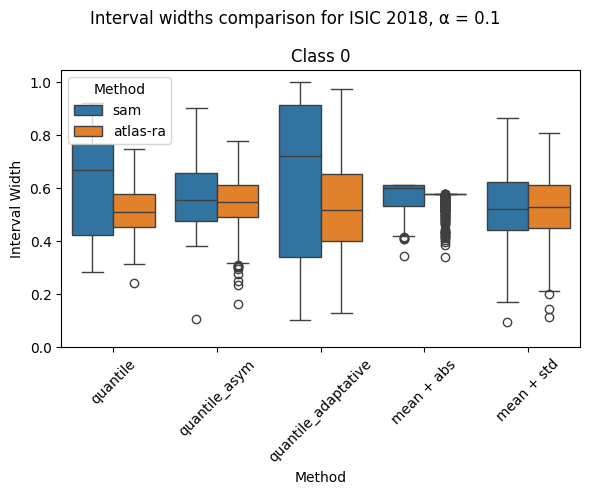

Number of calibration samples: 794


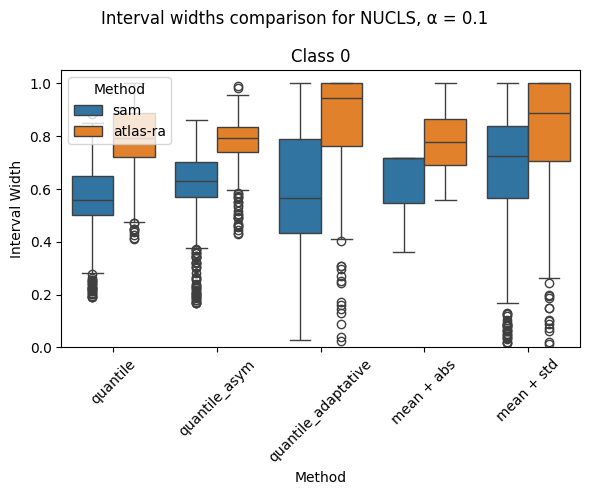

In [75]:
alpha = 0.1
models = ['sam', 'atlas-ra']
combinations = [(e, s) for e in ['mean'] for s in ['abs', 'std']]

for dataset in datasets:
    model_results = {}
    print(f'Number of calibration samples:', len(data['sam'][dataset]['cal']['Real score']))
    for model in models:
        conf_results = {}

        # Quantile-based
        conf_results['quantile'] = quantile_calibrate(
            data[model][dataset],
            p_l=0.4, p_h=0.95,
            alpha=alpha
        )

        conf_results['quantile_asym'] = quantile_calibrate_asymm(
            data[model][dataset],
            p_l=0.4, p_h=0.95,
            alpha_l=0.02, 
            alpha_u=0.08
        )

        conf_results['quantile_adaptative'] = quantile_calibrate_adaptative(
            data[model][dataset],
            p_l=0.4, p_h=0.95,
            alpha=alpha,
        )

        # Regression-based
        for estimator, sigma_type in combinations:
            label = f'{estimator} + {sigma_type}'
            conf_results[label] = conformal_calibrate(
                data[model][dataset],
                estimator=estimator,
                sigma_type=sigma_type,
                alpha=alpha,
            )

        model_results[model] = conf_results

    # Plot for this dataset
    plot_interval_size(model_results, title=f'Interval widths comparison for {dataset.upper()}, α = {alpha}')
    


Number of calibration samples: 329


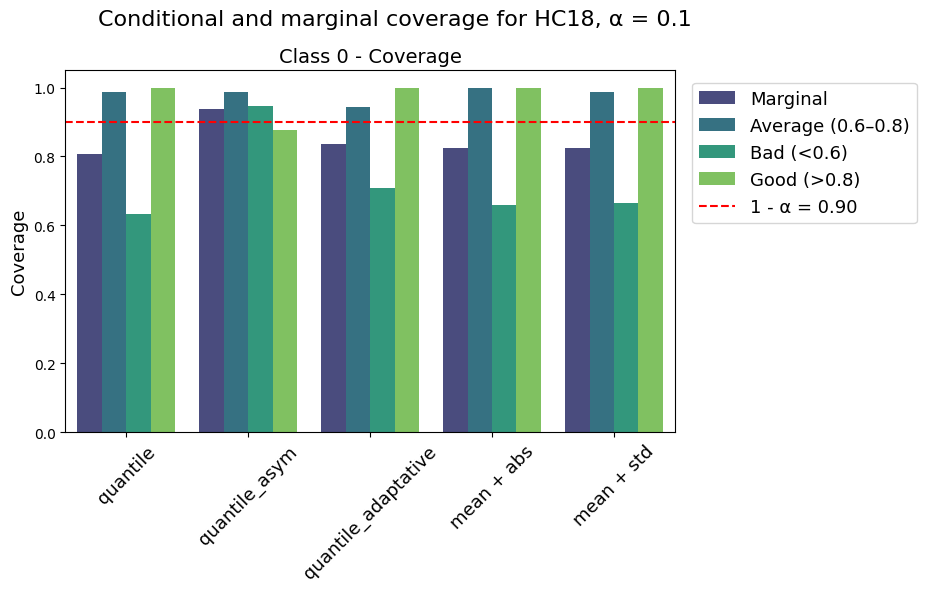

Number of calibration samples: 288


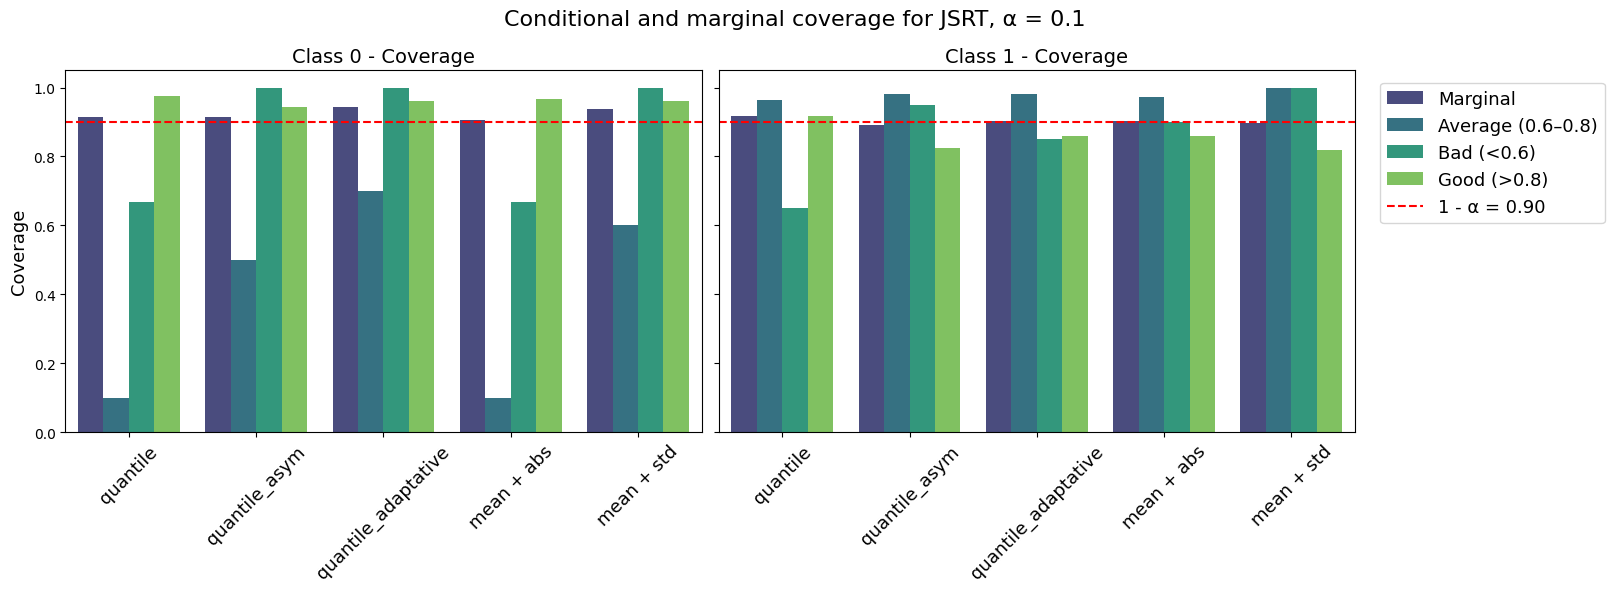

Number of calibration samples: 308


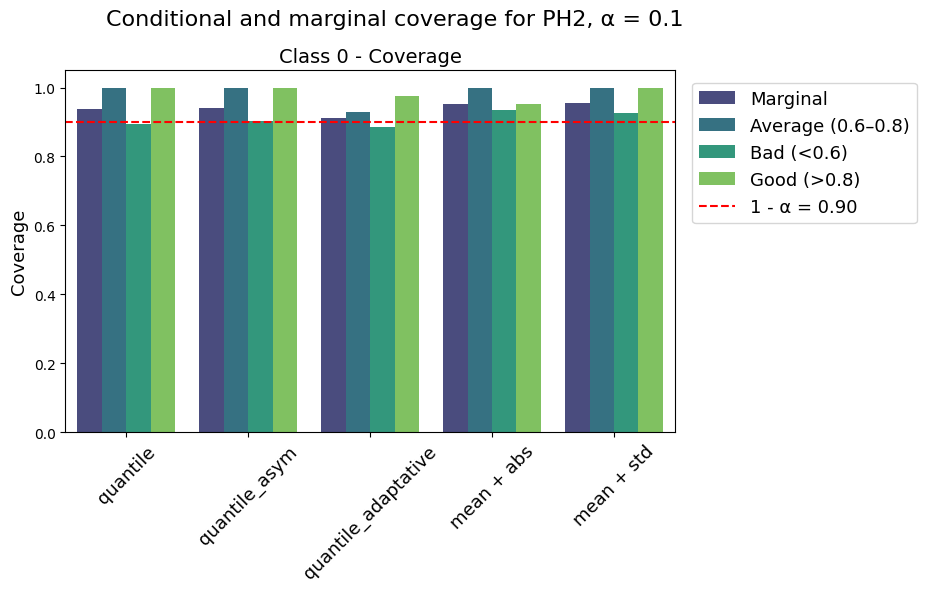

Number of calibration samples: 329


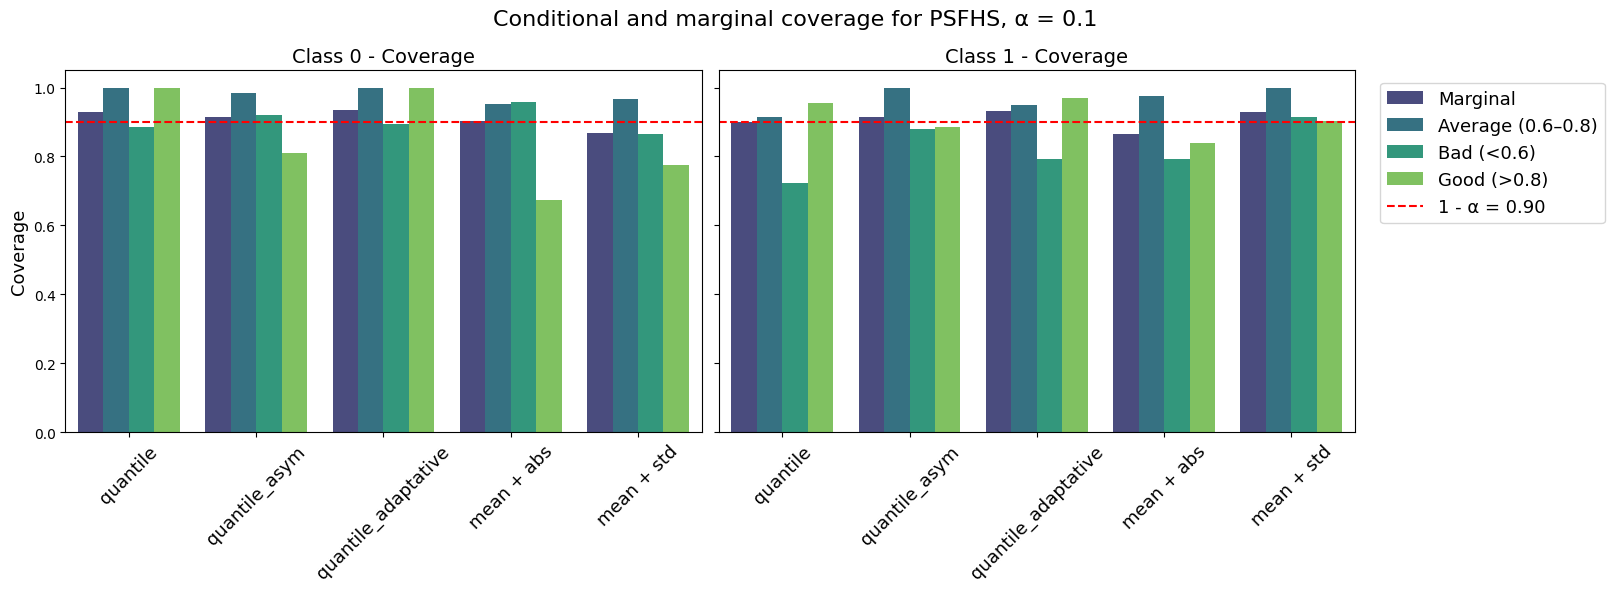

Number of calibration samples: 611


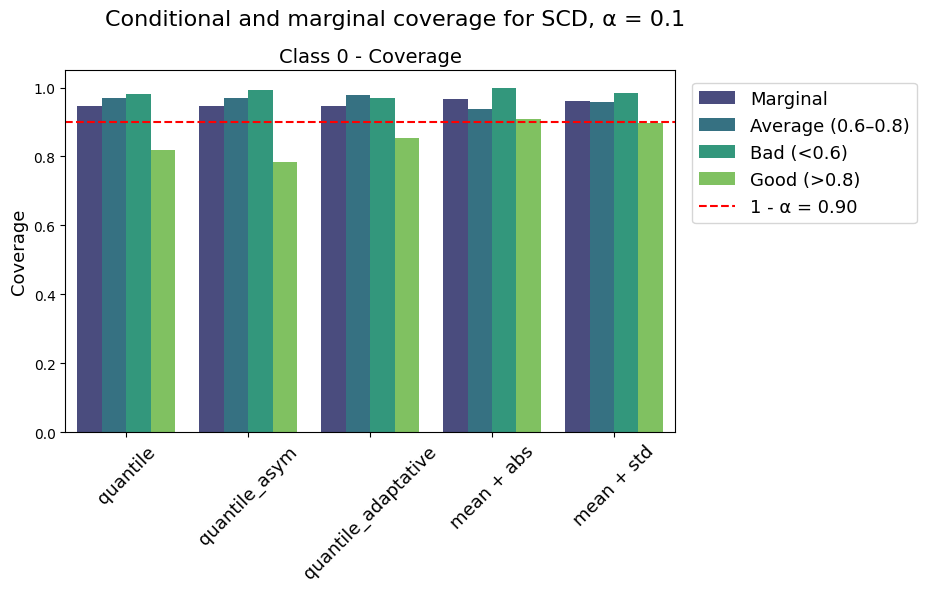

Number of calibration samples: 398


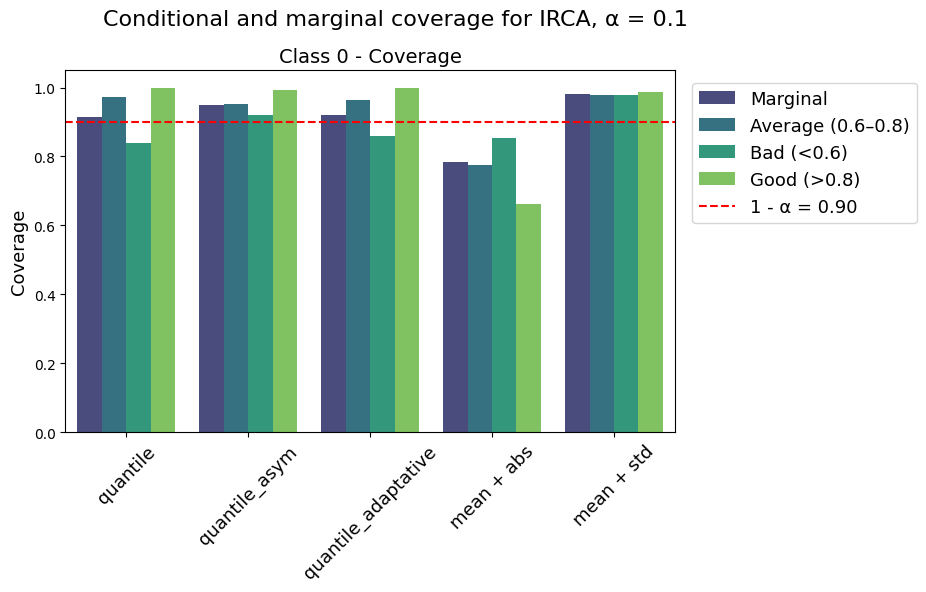

Number of calibration samples: 295


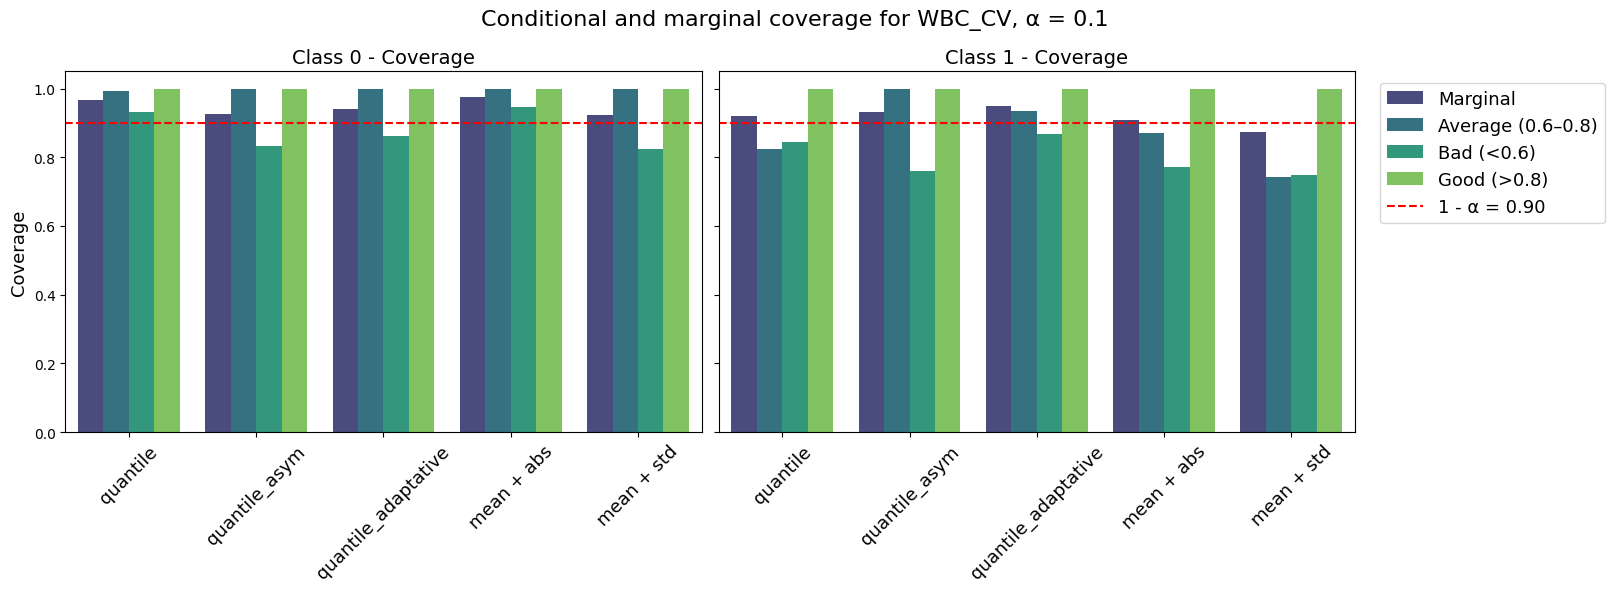

Number of calibration samples: 825


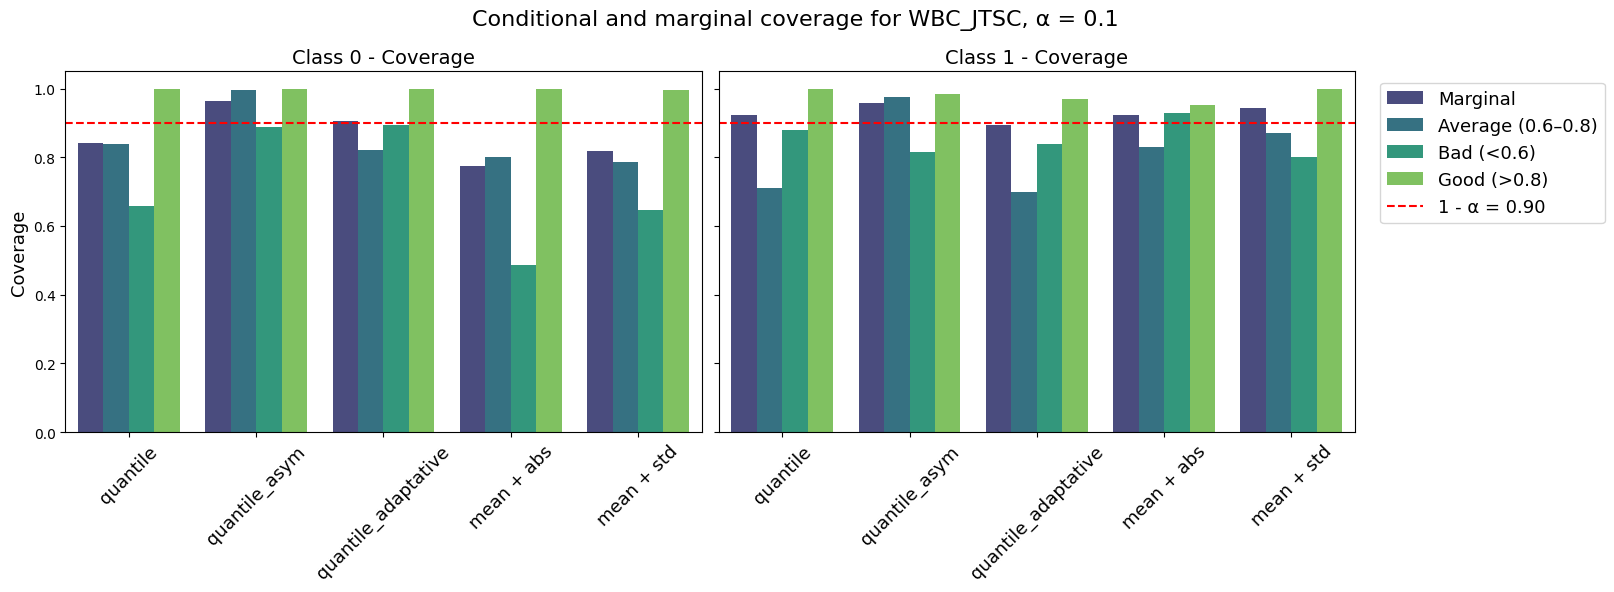

Number of calibration samples: 717


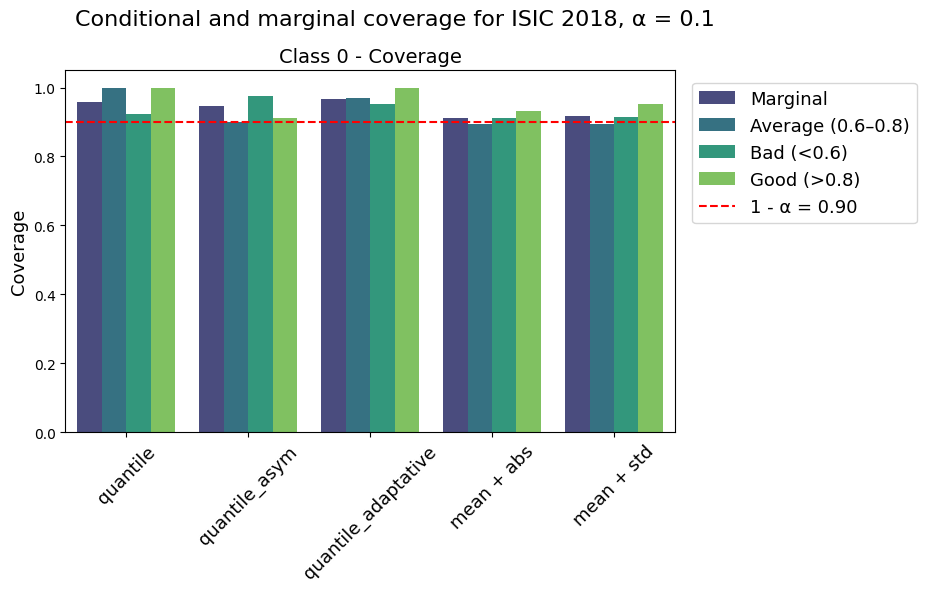

Number of calibration samples: 445


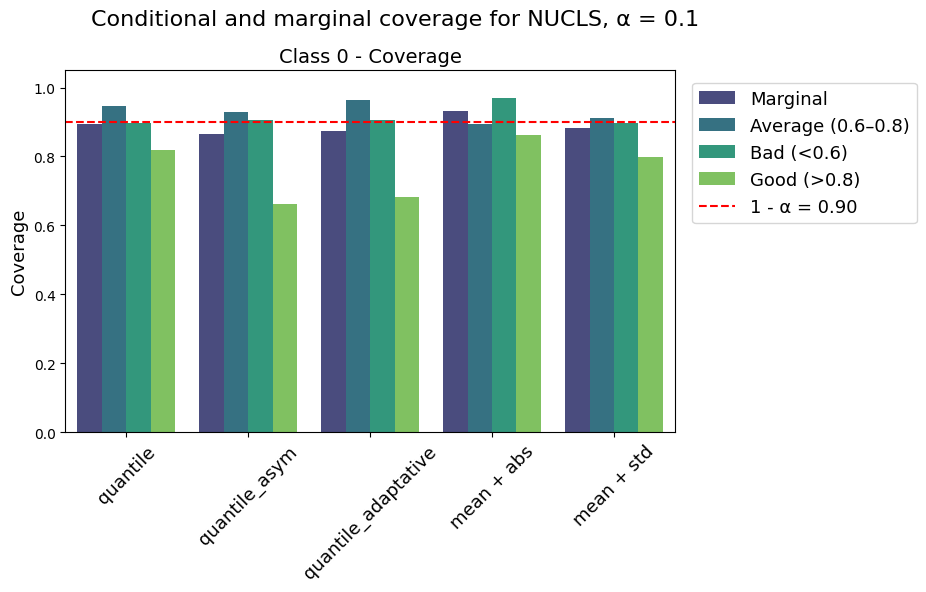

In [2]:
alpha = 0.1
n = 50
res_sam = data['sam']
combinations = [(e, s) for e in ['mean'] for s in ['abs', 'std']]

for dataset in datasets:
    print('Number of calibration samples:', len(res_sam[dataset]['cal']['Real score']))
    conf_results = {}

    # Quantile based
    conf_results['quantile'] = quantile_calibrate(
        res_sam[dataset], n=n,
        p_l=0.4, p_h=0.95,
        alpha=alpha
    )


    conf_results['quantile_asym'] = quantile_calibrate_asymm(
        res_sam[dataset], n=n,
        p_l=0.4, p_h=0.95,
        alpha_l=0.02, 
        alpha_u=0.08
    )

    conf_results['quantile_adaptative'] = quantile_calibrate_adaptative(
        res_sam[dataset], n=n,
        p_l=0.4, p_h=0.95,
        alpha=alpha,
    )

    # Regression based
    for estimator, sigma_type in combinations:
        label = f'{estimator} + {sigma_type}'
        conf_results[label] = conformal_calibrate(
            res_sam[dataset], n=n,
            estimator=estimator,
            sigma_type=sigma_type,
            alpha=alpha,
        )
    plot_coverage_analysis(conf_results, alpha=alpha, conditioning='value',
                           title=f'Conditional and marginal coverage for {dataset.upper()}, α = {alpha}')


KS test p-value = 0.0000
q̂ (quantile) = 0.1268
Calibration scores ≤ q̂: 0.903
Test scores ≤ q̂:        0.776


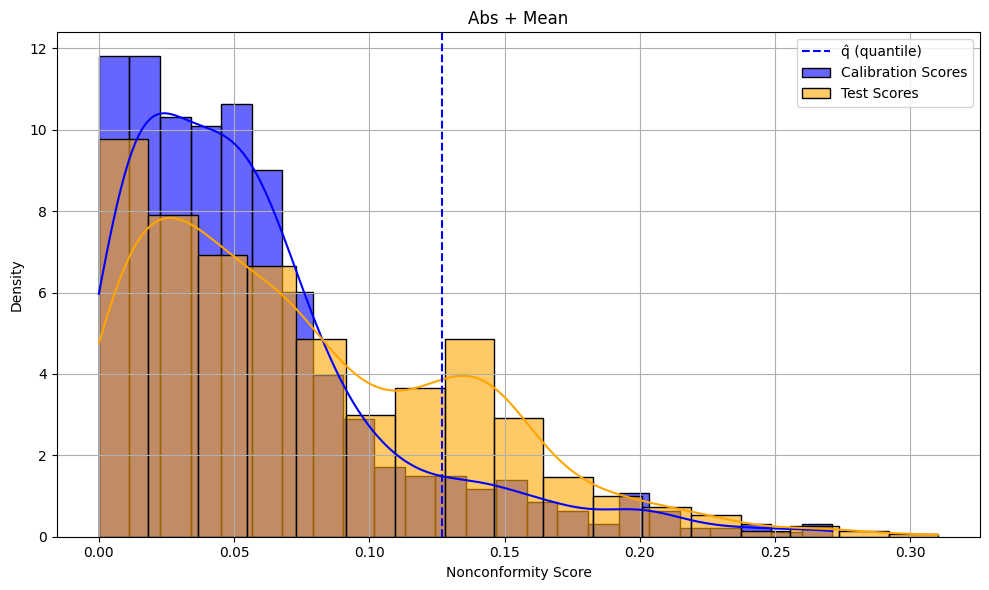

In [28]:
from scipy.stats import ks_2samp

def plot_nonconformity_histograms(result, title='Nonconformity Score Distributions'):
    """
    Plot histograms of calibration and test nonconformity scores,
    and print fraction of scores below q̂.

    Parameters:
        result: a dict returned by conformal_calibrate for a single class
        title: optional plot title
    """
    result = result[0]  # For single-class or class 0
    cal_scores = np.array(result['scores'])
    test_scores = np.array(result['test_scores'])

    qhat = result['q']
    cal_frac = np.mean(cal_scores <= qhat)
    test_frac = np.mean(test_scores <= qhat)

    # Print coverage info
    print(f"q̂ (quantile) = {qhat:.4f}")
    print(f"Calibration scores ≤ q̂: {cal_frac:.3f}")
    print(f"Test scores ≤ q̂:        {test_frac:.3f}")

    # Plot histograms
    plt.figure(figsize=(10, 6))
    sns.histplot(cal_scores, color='blue', label='Calibration Scores', kde=True, stat='density', alpha=0.6)
    sns.histplot(test_scores, color='orange', label='Test Scores', kde=True, stat='density', alpha=0.6)
    plt.axvline(qhat, color='blue', linestyle='--', label='q̂ (quantile)')
    plt.title(title)
    plt.xlabel('Nonconformity Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

alpha = 0.1
res = conformal_calibrate(data['sam']['wbc_jtsc'],estimator='mean',sigma_type='abs',alpha=alpha)
result = res[0]
cal_scores = np.array(result['scores'])
test_scores = np.array(result['test_scores'])

stat, p_value = ks_2samp(cal_scores, test_scores)
print(f"KS test p-value = {p_value:.4f}")
plot_nonconformity_histograms(res, title='Abs + Mean')